# NeuralNetwork

In [ ]:
# 패키지 import
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import warnings
import random
import torch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일 불러오기
def dataframe_from_csv(target):
  return pd.read_csv(target).rename(columns=lambda x:x.strip())

def dataframe_from_csvs(targets):
  return pd.concat([dataframe_from_csv(x) for x in targets])

train_files = sorted([x for x in Path('/content/drive/MyDrive/data/train').glob('*.csv')])
val_files = sorted([x for x in Path('/content/drive/MyDrive/data/val').glob('*.csv')])

train = dataframe_from_csvs(train_files)
val = dataframe_from_csvs(val_files)
test = pd.read_csv('/content/drive/MyDrive/Uni-d 데이터톤/data/dataset/test.csv')
print(f'train: {len(train)}')
print(f'validation: {len(val)}')
print(f'test: {len(test)}')

train: 62564
validation: 7820
test: 7820


In [ ]:
# 데이터 형태 파악하기 
train.head()

,site,sid,leaktype,C01,C02,C03,C04,C05,C06,C07,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,S-4687025030,S-0359369085120315,out,19,30,27,26,24,14,10,...,24,20,24,38,60,198,185,46,17,4680
1,S-4677025028,S-0359369083968368,out,2,343,46,22,12,8,6,...,2,2,2,2,2,4,2,2,2,300
2,S-4673025027,S-0359369085133797,out,0,36,5,3,3,0,3,...,0,0,3,3,3,3,3,3,3,240
3,S-4772025022,S-0359369084117593,out,2,24,4,4,2,2,2,...,2,4,2,4,4,4,4,2,4,370
4,S-4729010102,S-0359369084010178,out,3,25,5,5,5,5,5,...,5,5,6,8,6,5,5,6,5,430


In [ ]:
# data 정제
train = train.drop(['site', 'sid'], axis=1)
val = val.drop(['site', 'sid'], axis=1)
test = test.drop(['site', 'sid'], axis=1)
train['leaktype'].replace(['out','in','noise','other','normal'], [0,1,2,3,4], inplace=True)
val['leaktype'].replace(['out','in','noise','other','normal'], [0,1,2,3,4], inplace=True)
test['leaktype']=""

# train을 target과 feature로 나눠줍니다.
train_x=train.drop(['leaktype'], axis=1)
train_y=train['leaktype']
val_x=val.drop(['leaktype'], axis=1)
val_y=val['leaktype']
test_x=test.drop(['leaktype'], axis=1)
test_y=test['leaktype']

In [ ]:
# training set에 대해서 Z-Score 정규화
train_x_mean = train_x.mean()
train_x_std = train_x.std()
train_x_norm = (train_x - train_x_mean)/train_x_std

In [ ]:
# val set에 대해서 Z-Score 정규화
val_x_mean = val_x.mean()
val_x_std = val_x.std()
val_x_norm = (val_x - val_x_mean)/val_x_std

In [ ]:
# test set에 대해서 Z-Score 정규화
test_x_mean = test_x.mean()
test_x_std  = test_x.std()
test_x_norm = (test_x - test_x_mean)/test_x_std

In [ ]:
# np로 변경 
X_train_array = np.array(train_x)
y_train_array = np.array(train_y)
X_val_array = np.array(val_x)
y_val_array = np.array(val_y)
X_test_array = np.array(test_x)

In [ ]:
# 텐서 변경 
X_train = torch.FloatTensor(X_train_array)
y_train = torch.LongTensor(y_train_array)
X_val = torch.FloatTensor(X_val_array)
y_val = torch.LongTensor(y_val_array)
X_test = torch.FloatTensor(X_test_array)

In [ ]:
# 모델 구현 
class MyNeuralNet(nn.Module):
    def __init__(self):
        super(MyNeuralNet, self).__init__()

        self.layer1 = nn.Linear(26, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 32)
        self.layer4 = nn.Linear(32, 32)
        self.layer5 = nn.Linear(32, 5)


    def forward(self, x):
      x1 = F.relu(self.layer1(x))
      x2 = F.relu(self.layer2(x1))
      x3 = F.relu(self.layer3(x2))
      x4 = F.relu(self.layer4(x3))  
      x5 = F.relu(self.layer5(x4))   
      return x5

In [ ]:
# 데이터 로더 지정
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validate_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [ ]:
# initialization
learning_rate = 0.001
number_epoch = 500

model = MyNeuralNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

In [ ]:
def saveModel():
  torch.save(model.state_dict(), '/content/drive/MyDrive/newModel.pth')

In [ ]:
f1_val_mean = np.zeros((number_epoch))
loss_train_mean = np.zeros((number_epoch))

In [ ]:
# Training Function 
def train(num_epochs): 
    best_f1_score = 0.0 
    running_train_loss = 0.0
    running_vall_loss = 0.0

    model.train()
    print("Begin training...") 
    for epoch in tqdm(range(num_epochs)): 

        #plot을 위한 변수 선언
        f1_val_epoch = []
        loss_train_epoch = []
 
        # 모델 학습
        for X, y in train_loader:
            X = X  
            y = y

            # optimazation   
            optimizer.zero_grad()          
            predicted_y = model(X)   
            train_loss = loss(predicted_y, y)  
            train_loss.backward()   
            optimizer.step() 

            running_train_loss +=train_loss.item() 
            loss_train_epoch.append(train_loss.item()) # 데이터마다 loss 저장
 
        # train loss
        train_loss_value = running_train_loss/len(train_loader) 

        # Validation
        with torch.no_grad(): 
            model.eval() 
            for X, y in validate_loader: 
               X = X  
               y = y
               predicted_y = model(X) 
               val_loss = loss(predicted_y, y) 
 
               # prediction이 가장 큰 index가 label
               _, predicted = torch.max(predicted_y, 1) 
               running_vall_loss += val_loss.item()  
               val_f1_score = f1_score(predicted, y, average='micro')

               f1_val_epoch.append(val_f1_score.item()) # 데이터 마다 f1 저장
        
        # validation loss
        val_loss_value = running_vall_loss/len(validate_loader) 
 
 
        
        if val_f1_score > best_f1_score: 
            saveModel() 
            best_f1_score = val_f1_score
        
        # epoch 마다 train loss, f1_score 평균값 저장
        f1_val_mean[epoch] = np.mean(f1_val_epoch)
        loss_train_mean[epoch] = np.mean(loss_train_epoch)


In [ ]:
train(number_epoch)

Begin training...


100%|██████████| 500/500 [28:18<00:00,  3.40s/it]


In [ ]:
# 최종 train loss, f1_score 
print("final loss is", loss_train_mean[-1])
print("final f1_score is", f1_val_mean[-1])

final loss is 0.4428575431703302
final f1_score is 0.6971186155913978


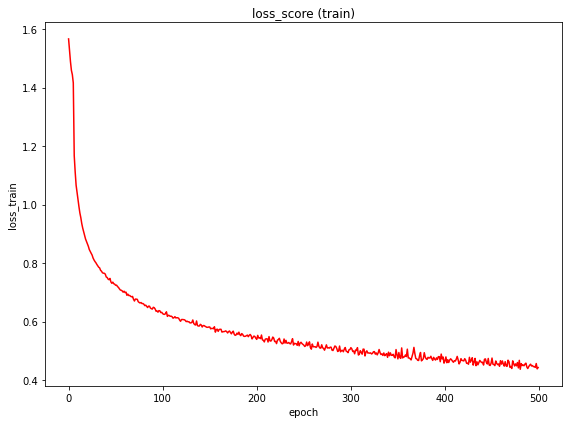

In [ ]:
# epoch 마다 loss plot
title = 'loss_score (train)'
label_axis_x    = 'epoch' 
label_axis_y    = 'loss_train'
color_mean      = 'red'
alpha           = 0.3

plt.figure(figsize=(8, 6))
plt.title(title)

plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
  
plt.xlabel(label_axis_x)
plt.ylabel(label_axis_y)

plt.tight_layout()
plt.show()

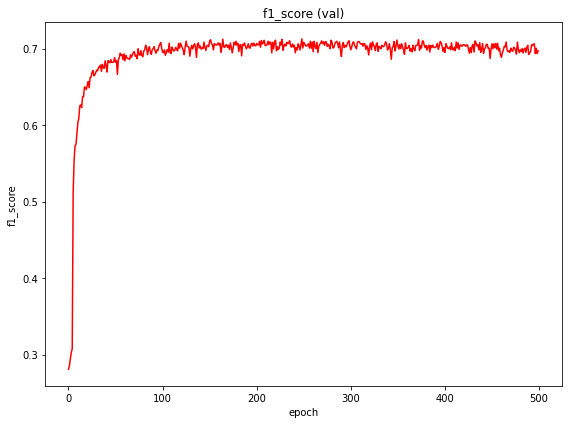

In [ ]:
# epoch 마다 f1 plot
title = 'f1_score (val)'
label_axis_x    = 'epoch' 
label_axis_y    = 'f1_score'
color_mean      = 'red'
alpha           = 0.3

plt.figure(figsize=(8, 6))
plt.title(title)

plt.plot(range(len(f1_val_mean)), f1_val_mean, '-', color = color_mean)
  
plt.xlabel(label_axis_x)
plt.ylabel(label_axis_y)

plt.tight_layout()
plt.show()

In [ ]:
# 제출파일 생성
submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
final_model = MyNeuralNet()
final_model.load_state_dict(torch.load('/content/drive/MyDrive/newModel.pth'))
final_model.eval()
H = final_model(X_test)
test_pred = torch.argmax(H, dim = 1)
submission['leaktype']=test_pred
submission

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,...,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1,site,sid,leaktype
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,S-4784025026,S-0359369085186035,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,S-4521010100,S-0359369084102843,4
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,S-2911010107,S-0359369084039755,4
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,S-2711010100,S-0359369084044425,0
4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,S-4677025033,S-0359369083955449,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,7815,7815,7815,7815,7815,7815,7815,7815,7815,7815,...,7815,7815,7815,7815,7815,7815,7815,S-4677025029,S-0359369081312577,4
7816,7816,7816,7816,7816,7816,7816,7816,7816,7816,7816,...,7816,7816,7816,7816,7816,7816,7816,S-4772025022,S-0359369084106224,4
7817,7817,7817,7817,7817,7817,7817,7817,7817,7817,7817,...,7817,7817,7817,7817,7817,7817,7817,S-4673025027,S-0359369085149850,0
7818,7818,7818,7818,7818,7818,7818,7818,7818,7818,7818,...,7818,7818,7818,7818,7818,7818,7818,S-4571025029,S-0359369084043617,4


In [ ]:
submission.to_csv('/content/drive/MyDrive/data/sample_submission.csv', index = False)

# new: XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

param_tuning = {
    'learning_rate': [0.2, 0.5],
    'max_depth': [3, 6],
    'subsample': [0.5, 1],
    'n_estimators' : [100, 200],
}

xgb_model = xgb.XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                        param_grid = param_tuning,                        
                        cv = 3,
                        n_jobs = -1,
                        verbose = 1)

gsearch.fit(train_x,train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[04:54:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.5, 1]},
             verbose=1)

In [ ]:
xgbb = xgb.XGBRegressor( eval_metric='mlogloss', interaction_constraints='',
             learning_rate=0.5, max_depth=6, n_jobs=0, num_class=5, n_estimators= 100,
             num_parallel_tree=1, objective='multi:softprob', random_state=42,
             scale_pos_weight=None, seed=42, tree_method='exact',
             validate_parameters=1)

In [ ]:
gsearch.best_params_

{'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1}

In [ ]:
xgbb.base_score

0.5

In [ ]:
xgbb.fit(train_x, train_y)

XGBRegressor(eval_metric='mlogloss', interaction_constraints='',
             learning_rate=0.5, max_depth=6, n_jobs=0, num_class=5,
             num_parallel_tree=1, objective='multi:softprob', random_state=42,
             scale_pos_weight=None, seed=42, tree_method='exact',
             validate_parameters=1)

In [ ]:
# val 추론
y_pred = xgbb.predict(val_x).argmax(axis=1)

In [ ]:
y_pred

array([2, 0, 0, ..., 4, 4, 4])

In [ ]:
print("Validation F1 score: ", f1_score(val_y, y_pred, average = 'micro'))

Validation F1 score:  0.7345268542199489


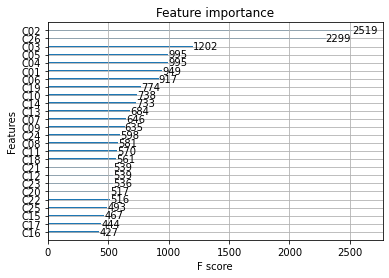

In [ ]:
xgb.plot_importance(xgbb)

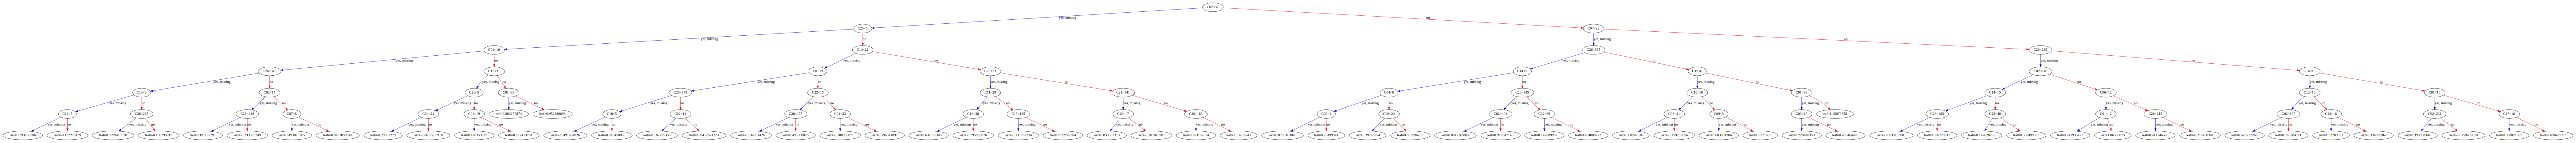

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_tree(xgbb, num_trees=0)

fig = plt.gcf()
fig.set_size_inches(150, 100)

plt.show()